In [37]:
%matplotlib inline
from __future__ import print_function, division, absolute_import
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})
matplotlib.rcParams["savefig.dpi"] = 150.0
matplotlib.rcParams["figure.dpi"] = 150.0
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.core.display import display
import seaborn as sns
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")


# Construct the catalog

## Read in Megan Bedell's x-matched GAIA DR2-Kepler stellar catalog

from <a href="gaia-kepler.fun">gaia-kepler.fun</a>.

In [38]:
kepler_dr2 = Table.read('kepler_dr2_1arcsec.fits', format='fits')
df1 = kepler_dr2.to_pandas()

In [39]:
print(np.array(df1.columns))
print(len(df1))

['designation' 'source_id' 'gaia_ref_epoch' 'ra' 'ra_error' 'dec'
 'dec_error' 'parallax' 'parallax_error' 'parallax_over_error' 'pmra'
 'pmra_error' 'pmdec' 'pmdec_error' 'ra_dec_corr' 'ra_parallax_corr'
 'ra_pmra_corr' 'ra_pmdec_corr' 'dec_parallax_corr' 'dec_pmra_corr'
 'dec_pmdec_corr' 'parallax_pmra_corr' 'parallax_pmdec_corr'
 'pmra_pmdec_corr' 'astrometric_chi2_al' 'astrometric_excess_noise'
 'astrometric_excess_noise_sig' 'astrometric_primary_flag'
 'duplicated_source' 'phot_g_mean_flux' 'phot_g_mean_flux_error'
 'phot_g_mean_mag' 'phot_bp_mean_flux' 'phot_bp_mean_flux_error'
 'phot_bp_mean_mag' 'phot_rp_mean_flux' 'phot_rp_mean_flux_error'
 'phot_rp_mean_mag' 'bp_rp' 'bp_g' 'g_rp' 'radial_velocity'
 'radial_velocity_error' 'phot_variable_flag' 'l' 'b' 'ecl_lon' 'ecl_lat'
 'teff_val' 'teff_percentile_lower' 'teff_percentile_upper' 'a_g_val'
 'a_g_percentile_lower' 'a_g_percentile_upper' 'e_bp_min_rp_val'
 'e_bp_min_rp_percentile_lower' 'e_bp_min_rp_percentile_upper'
 'radius_va

## Read in McQuillan et al. (2014) catalog of Kepler rotation periods

from Vizier

In [40]:
kepler_prot = Table.read('J_ApJS_211_24_t1.fits', format='fits', hdu=1)
df2 = kepler_prot.to_pandas()

In [41]:
print(np.array(df2.columns))
print(len(df2))

['KIC' 'Teff' 'log_g_' 'Mass' 'Prot' 'e_Prot' 'n_Prot' 'Rper' 'LPH' 'w'
 'Ref' '_RA' '_DE']
34030


## Merge the two

Use left join to keep all entries in the GAIA-Kepler x-match for now

In [42]:
df=df1.merge(df2, how='left', left_on='kepid', right_on='KIC')
print(len(df))

197090


remove rows with no entries in McQuillan catalog

In [43]:
df=df.dropna(subset=['Prot'])
print(len(df))

33853


Remove duplicates (for now keep closest match only - may not be the right one of course). 
Thanks Oli Hall for the function.

In [44]:
def kill_duplicates(df,ID, sep):
    '''A function that kills duplciates in a pandas dataframe on a given separation column.
    Input:
        df (pandas dataframe): A pandas dataframe of the data you want to kill duplicates for.
        
        ID (str): The label of the ID column (i.e. KIC, 2MASS). This is used to find the duplicates.
        
        sep (str): The label of the separation column. This is used to cut the duplicates.
        
    Returns:
        df (pandas dataframe): The input pandas dataframe with duplicates killed.
    '''
    df = df.copy(deep=True)
    sel = df.duplicated(ID, keep=False)
    s = df[sel]
    for idx in range(s[ID].nunique()):
        subset = s[s[ID] == s[ID].values[idx]]
        lock = True  #Iterate and remove the target of largest separation
        while lock:
            if len(subset) > 1.:
                drop = subset[sep].idxmax()
                subset.drop(drop, inplace=True)
                s.drop(drop,inplace=True)
                df.drop(drop, inplace=True)
            elif len(subset == 1.):
                lock = False
            else:
                print('The code shouldnt be here?')
    return df

In [45]:
df = kill_duplicates(df,'source_id','kepler_gaia_ang_dist')
print(len(df))

/Users/aigrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/aigrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


33808


## Compute total proper motion, and from that tangential velocity


In [49]:
df['pmtot'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)
au2km = 149597870.700
yr2s = 3600.0*24*365.25
df['vtan'] = df['pmtot'] * df['r_est'] * au2km / yr2s / 1e3
df=df.dropna(subset=['parallax','bp_rp','pmtot','r_est','vtan'])
print(len(df))

33228


## Quality cuts following Davenport & Covey (2018)

In [84]:
ok = ((df[u'parallax_error'] < 0.1) &
      (df[u'r_modality_flag'] == 1) & 
      (df[u'r_result_flag'] == 1) &
      (df[u'phot_bp_mean_flux_error']/df[u'phot_bp_mean_flux'] < 0.01) & 
      (df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01) & 
      (df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01))
ok.sum()

30537

# Plot the GAIA CMD

## Compute distance modulus, and from that absolute G-mag

In [88]:
mu = 5 * np.log10(df['r_est']) - 5
df['M_G'] = df['phot_g_mean_mag'] - mu #- df['a_g_val']

## Read in MIST v1.1 1 Gyr [Fe/H]=0.25  isochrone

In [89]:
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = '/Data/Models/Dartmouth/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
#MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)
mist_ms1 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] == 9.) & 
                    (mist['Gaia_G_DR2Rev'] > 2))[0][::-1]

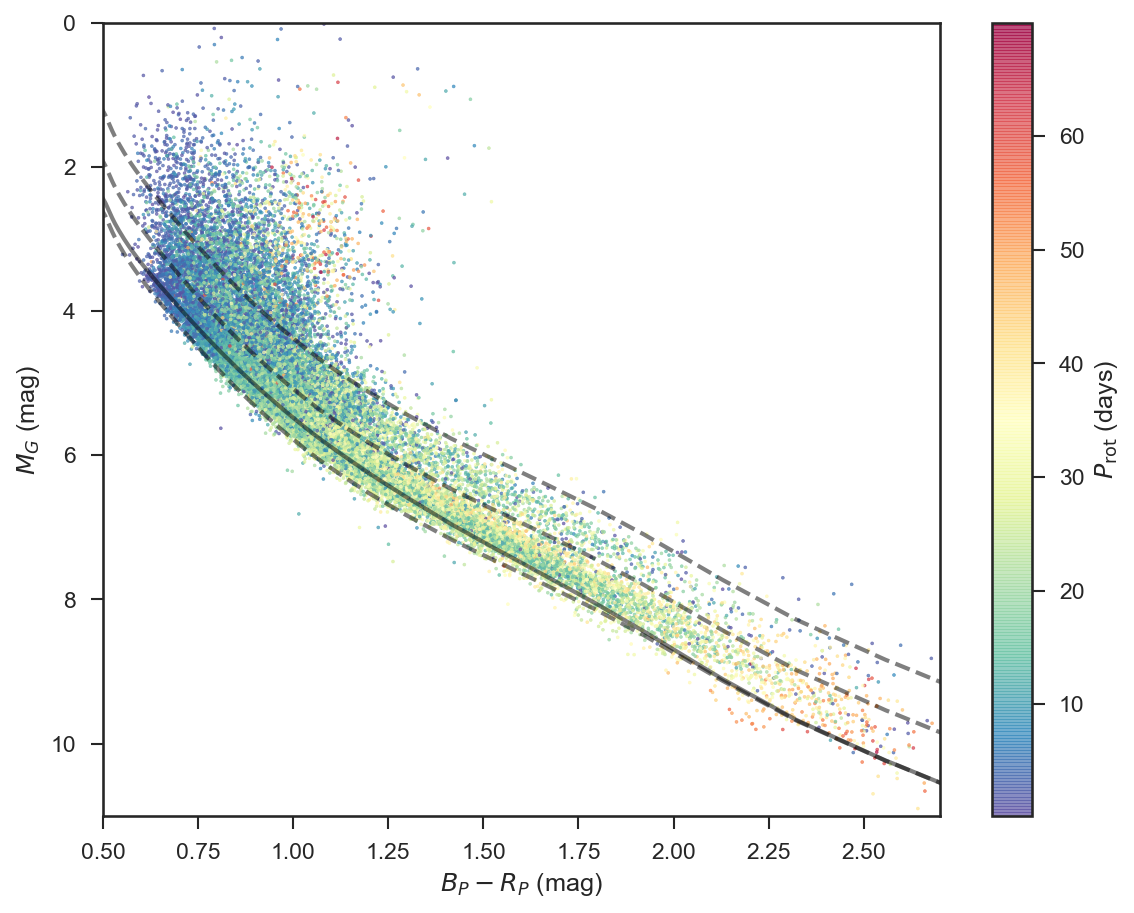

In [162]:

plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')
plt.scatter( df[u'bp_rp'].values[ok], df[u'M_G'].values[ok], c = df[u'Prot'].values[ok], alpha=0.7, s=2, cmap=cm)
#plt.plot(t['Gaia_BP']-t['Gaia_RP'], t['Gaia_G'], c='k', lw=2, alpha=0.5)
plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.5)

x = mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1]
y =  mist['Gaia_G_DR2Rev'].values[mist_ms1]
y1 = y + 0.3*np.exp(-2*(x-1)**2)
y2 = y1 - 0.7
y3 = y2 - 0.7
plt.plot(x, y1, 'k--',lw=2,alpha=0.5)
plt.plot(x, y2, 'k--',lw=2,alpha=0.5)
plt.plot(x, y3, 'k--',lw=2,alpha=0.5)
plt.ylim(11,0)
plt.xlim(.5,2.7)
plt.xlabel('$B_P - R_P$ (mag)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('$P_{\mathrm{rot}}$ (days)');

## Select single and binary MS stars 

The MIST V1.1 isochrone matches the bottom of the MS quite well except near $B_P-R_P \sim 1$. Let's apply a small modification: $M_G = M_{G,0} + 0.3 \exp\left[-2(B_P-R_P-1)^2\right]$. Then shift upwards by 0.7 mag to define single star MS, and another 0.7 mag to define binary star MS.

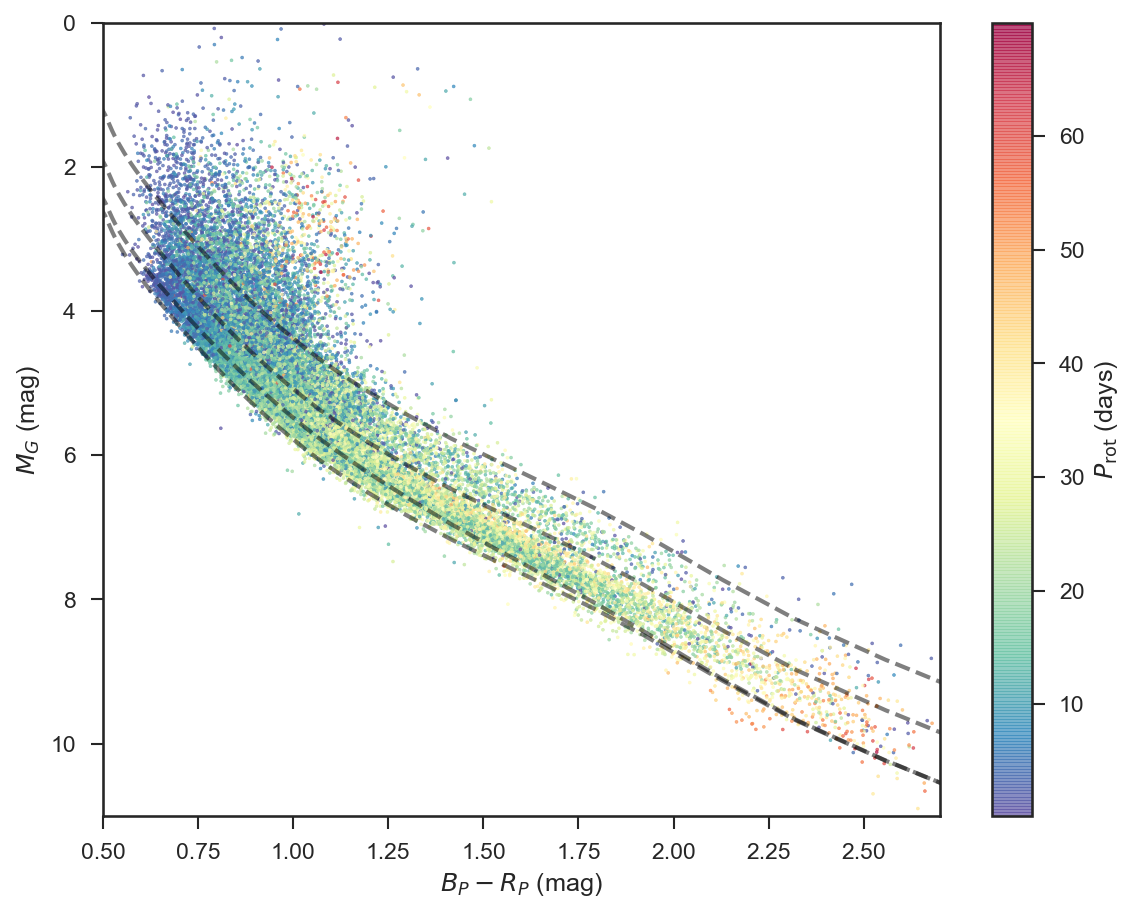

In [161]:

plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')
plt.scatter( df[u'bp_rp'].values[ok], df[u'M_G'].values[ok], c = df[u'Prot'].values[ok], alpha=0.7, s=2, cmap=cm)
x = mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1]
y =  mist['Gaia_G_DR2Rev'].values[mist_ms1]
y1 = y + 0.3*np.exp(-2*(x-1)**2)
y2 = y1 - 0.7
y3 = y2 - 0.7
plt.plot(x, y, 'k--',lw=2,alpha=0.5)
plt.plot(x, y1, 'k--',lw=2,alpha=0.5)
plt.plot(x, y2, 'k--',lw=2,alpha=0.5)
plt.plot(x, y3, 'k--',lw=2,alpha=0.5)
plt.ylim(11,0)
plt.xlim(.5,2.7)
plt.xlabel('$B_P - R_P$ (mag)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('$P_{\mathrm{rot}}$ (days)');

In [164]:
# vertical distance from MS 
Mg_ZAMS = np.interp(df[u'bp_rp'].values, x, y1)
delta_mag_ZAMS = Mg_ZAMS - df[u'M_G'].values
# approx cut for single main sequence stars
ms1 = (delta_mag_ZAMS >= 0.0) & (delta_mag_ZAMS < 0.7) 
ms2 = (delta_mag_ZAMS >= 0.7) & (delta_mag_ZAMS < 1.4) 

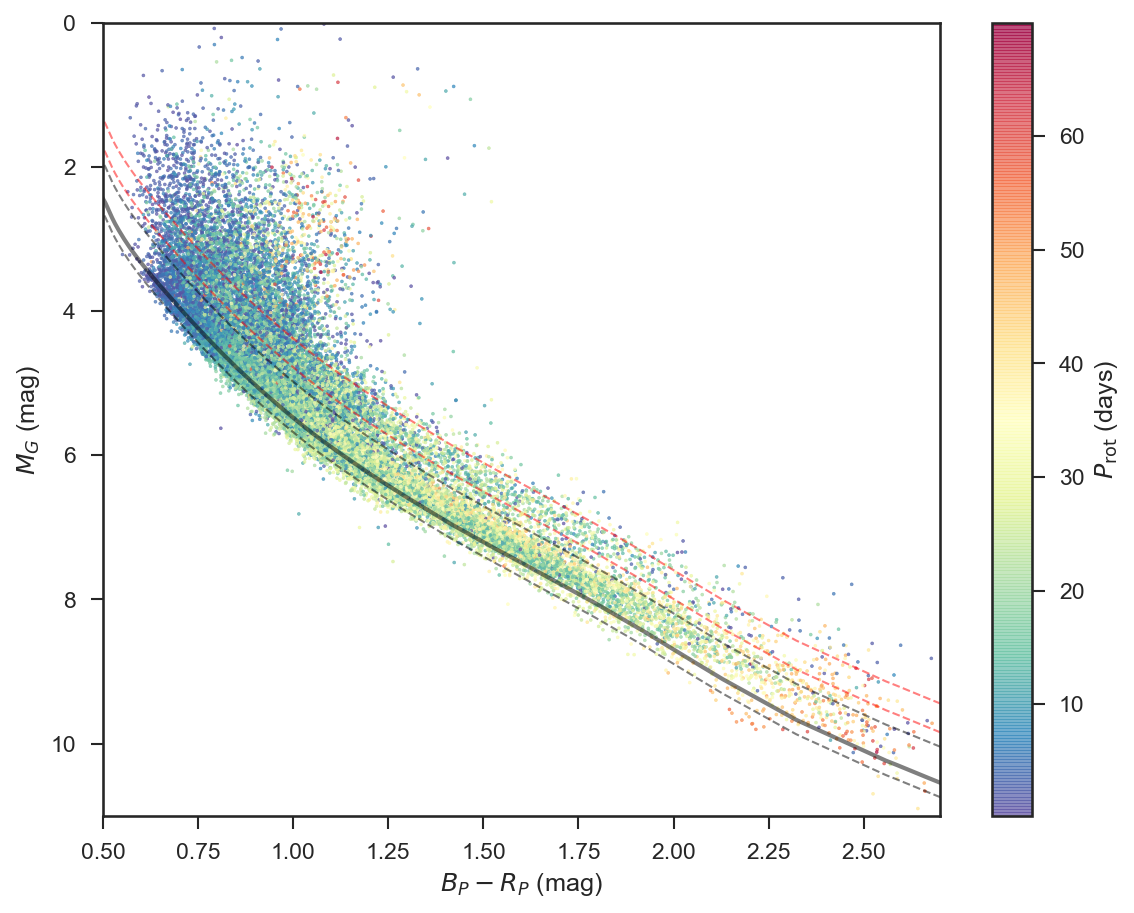

In [82]:

plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')
plt.scatter( df[u'bp_rp'].values[ok], df[u'M_G'].values[ok], c = df[u'Prot'].values[ok], alpha=0.7, s=2, cmap=cm)
#plt.plot( df[u'bp_rp'].values[msok], df[u'M_G'].values[msok], 'k.',ms=4)

#plt.plot(t['Gaia_BP']-t['Gaia_RP'], t['Gaia_G'], c='k', lw=2, alpha=0.5)
plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.5)
plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1]-dmag_lims[0][1], c='k', lw=1, alpha=0.5,ls='dashed')
plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1]-dmag_lims[0][0], c='k', lw=1, alpha=0.5,ls='dashed')
plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1]-dmag_lims[1][1], c='r', lw=1, alpha=0.5,ls='dashed')
plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1]-dmag_lims[1][0], c='r', lw=1, alpha=0.5,ls='dashed')


plt.ylim(11,0)
plt.xlim(.5,2.7)
plt.xlabel('$B_P - R_P$ (mag)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('$P_{\mathrm{rot}}$ (days)');

## Select stars within 1000 pc

In [78]:
l1 = df['r_est'] <= 500
l2 = (df['r_est'] <= 700) * (df['r_est'] > 500)

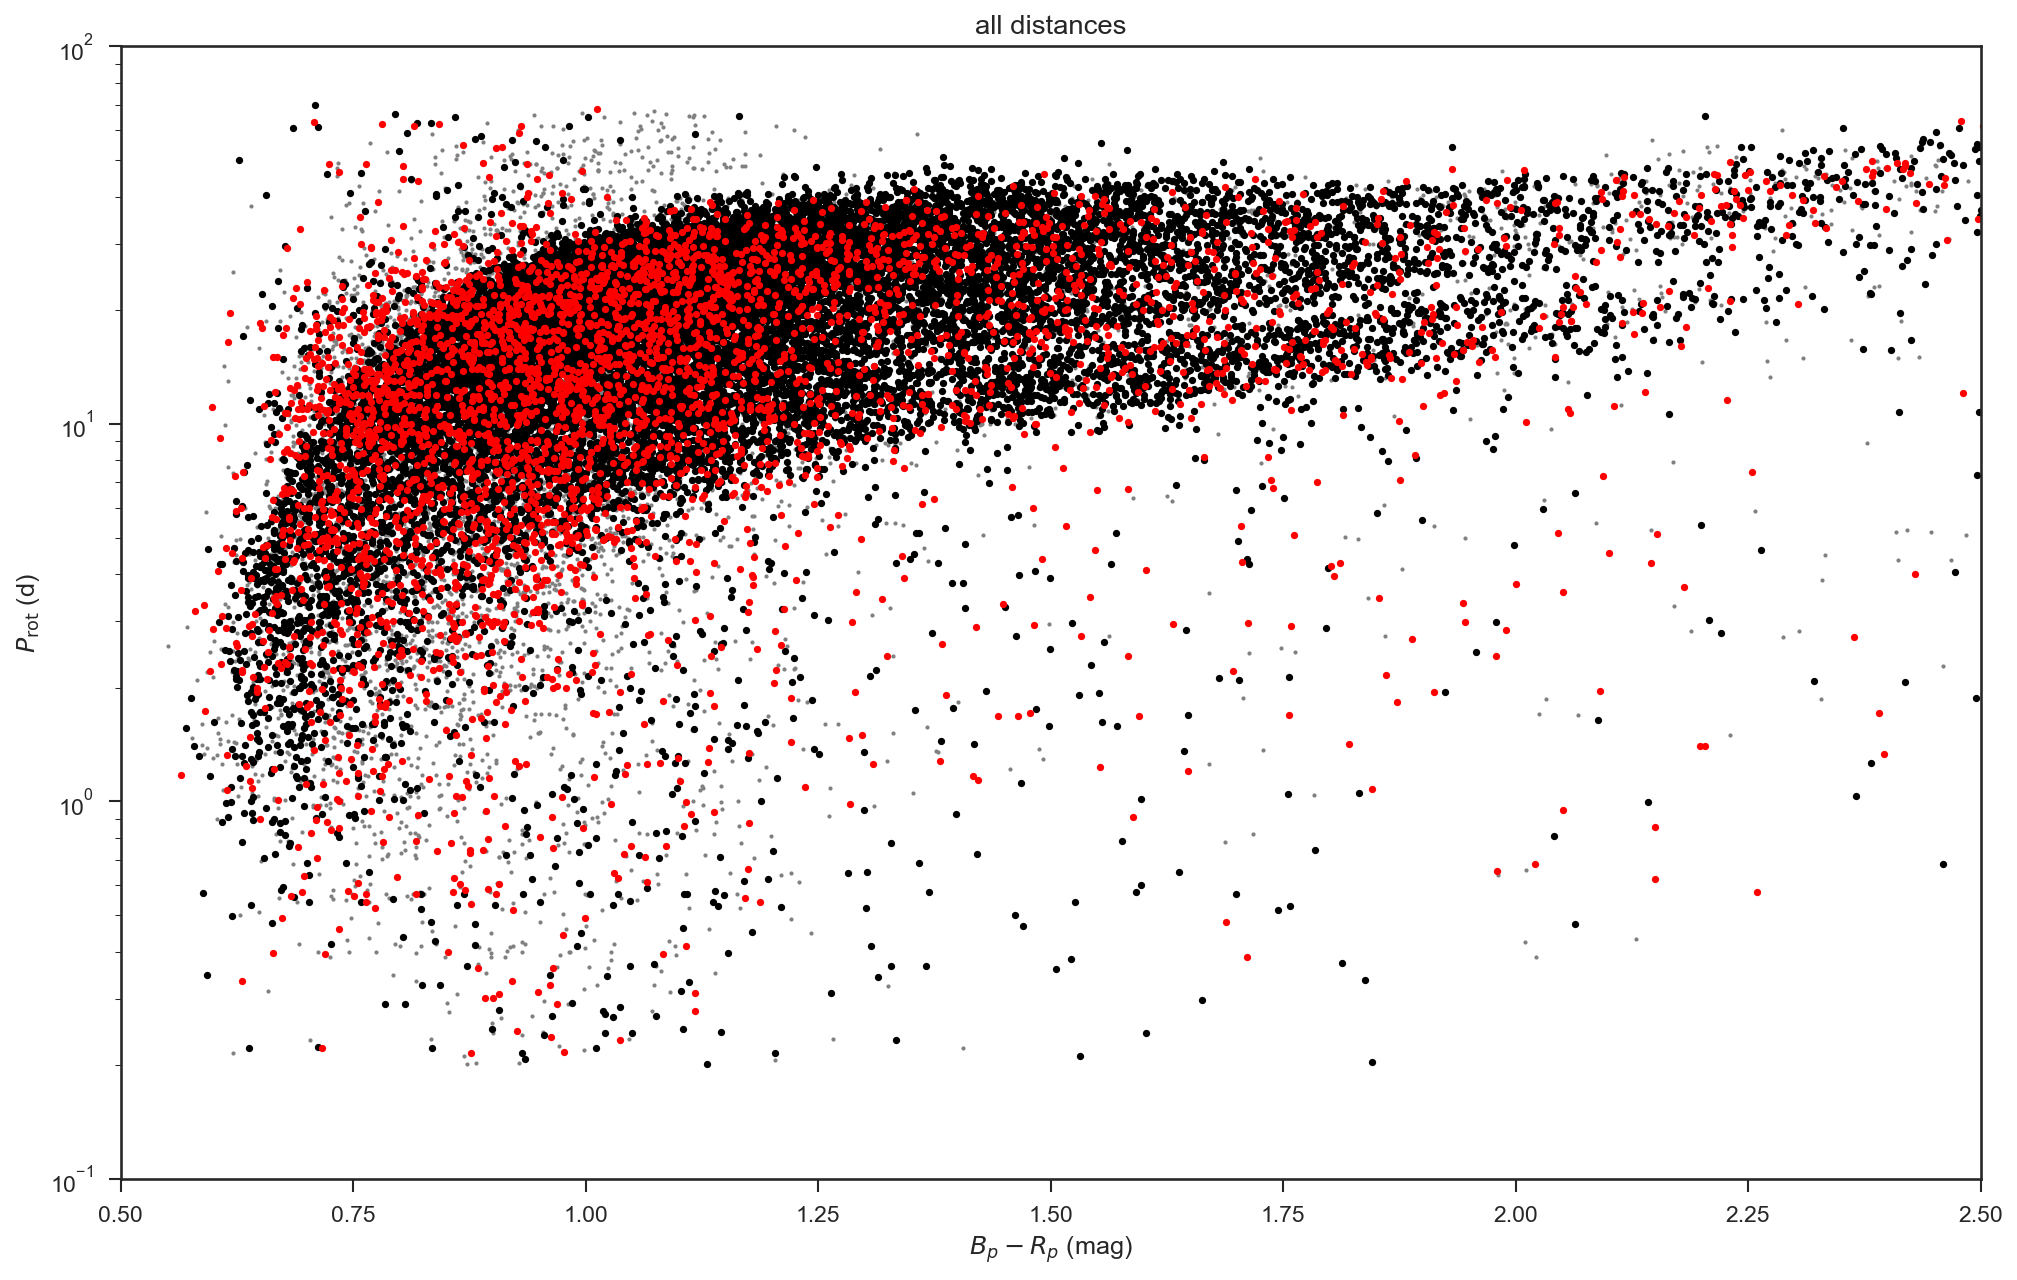

In [83]:
plt.figure(figsize=(16,10))
x = np.array(df['bp_rp']).flatten()
y = np.array(df['Prot']).flatten()
c = np.log10(np.array(df['vtan']).flatten())
plt.plot(df[u'bp_rp'].values[ok],df[u'Prot'].values[ok],'.',c='grey',ms=4)
plt.plot(df[u'bp_rp'].values[msok],df[u'Prot'].values[msok],'k.')
plt.plot(df[u'bp_rp'].values[bsok],df[u'Prot'].values[bsok],'r.')
#plt.scatter(x[MSS], y[MSS], s = 20, c = c[MSS], alpha=0.5)
#plt.colorbar(label='$\log_{10} V_{\mathrm{tan}}$ (km/s)')
plt.semilogy()
plt.xlim(0.5,2.5)
plt.ylim(0.1,100) 
#plt.legend(loc=0)
plt.title('all distances')
plt.xlabel(r'$B_p-R_p$ (mag)')
plt.ylabel(r'$P_{\mathrm{rot}}$ (d)');

In [ ]:
plt.figure(figsize=(16,10))
x = np.array(df['bp_rp']).flatten()
y = np.array(df['Prot']).flatten()
c = np.log10(np.array(df['vtan']).flatten())
plt.scatter(x[MSS*l1], y[MSS*l1], s = 20, c = c[MSS*l1], alpha=0.5)
plt.colorbar(label='$\log_{10} V_{\mathrm{tan}}$ (km/s)')
plt.semilogy()
plt.xlim(0.5,2.5)
plt.ylim(0.1,100)
plt.legend(loc=0)
plt.title(r'$d<500$ pc')
plt.xlabel(r'$B_p-R_p$ (mag)')
plt.ylabel(r'$P_{\mathrm{rot}}$ (d)');

In [ ]:
plt.figure(figsize=(16,10))
x = np.array(df['bp_rp']).flatten()
y = np.array(df['Prot']).flatten()
c = np.log10(np.array(df['vtan']).flatten())
plt.scatter(x[MSS*l2], y[MSS*l2], s = 20, c = c[MSS*l2], alpha=0.5)
plt.colorbar(label='$\log_{10} V_{\mathrm{tan}}$ (km/s)')
plt.semilogy()
plt.xlim(0.5,2.5)
plt.ylim(0.1,100)
plt.legend(loc=0)
plt.title(r'$500<d<700$ pc')
plt.xlabel(r'$B_p-R_p$ (mag)')
plt.ylabel(r'$P_{\mathrm{rot}}$ (d)');